<br><br><br><br><br>

# Coding fast and fast code

<br><br><br><br><br>

<center><img src="img/commute-by-plane.png" width="65%"></center>

_(Stolen from Jake Vanderplas.)_

<br><br><br><br><br>

**Extended analogy:** drive your car to the airport, then take an airplane.

<br><br><br><br><br>

<br><br>

#### Typical analysis workflow

   1. Start with small dataset; plot some things, compute some things, get a sense of the data.
   2. Collect one-liners, notebook cells, scripts into an executable.
   3. Run the executable on ever-larger datasets.
   4. Run it in different ways to quantify systematic errors.
   5. Realize that it wasn't written efficiently enough to finish analysis before deadline.
   6. Rewrite it in a faster language (e.g. Python → C++).
   7. Wonder why the new code doesn't reproduce the old results.

The problem is **step 6**: frameworks should allow you to improve (cleanliness, execution time) in _small steps,_ not _major rewrites._

<br><br>

In [43]:
# Example problem: computing a fractal (calendar/mousepad/T-shirt...).
import time

def run_python(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_python(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

5632.271369298299 ns per pixel


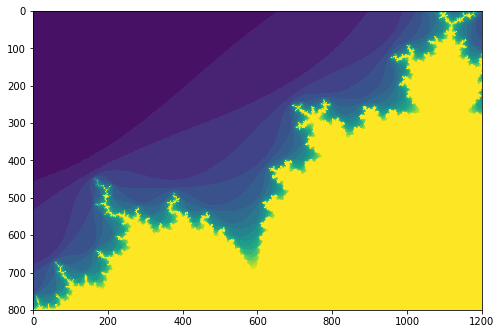

In [18]:
%matplotlib inline
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(figsize=(10, 5.5))
ax.imshow(fractal);

In [44]:
# Numpy operates array-at-a-time, you have to completely rethink the "iterate until converged" part.
import numpy

def run_numpy(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_numpy(1600, 2400)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

339.94348098834354 ns per pixel


In [47]:
# But once it's in a Numpy-friendly form, it's ready for GPUs.
import cupy

def run_cupy(height, width, maxiterations=20):
    y, x = cupy.ogrid[-1:0:height*1j, -1.5:0:width*1j]               # <--- changed this line
    c = x + y*1j
    fractal = cupy.full(c.shape, maxiterations, dtype=numpy.int32)   # <--- changed this line
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_cupy(1600, 2400)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

77.292633553346 ns per pixel


In [80]:
# Dask can keep all of your processors busy, but it might be making a more complex graph than you want.
import dask.array

def run_dask(height, width, maxiterations=20, hchunks=3, vchunks=4):
    chunked = lambda a: dask.array.from_array(a, chunks=(height // hchunks, width // vchunks))
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = chunked(x + y*1j)
    fractal = chunked(numpy.full(c.shape, maxiterations, dtype=numpy.int32))
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_dask(1600, 2400).compute()
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

225.02982368071875 ns per pixel


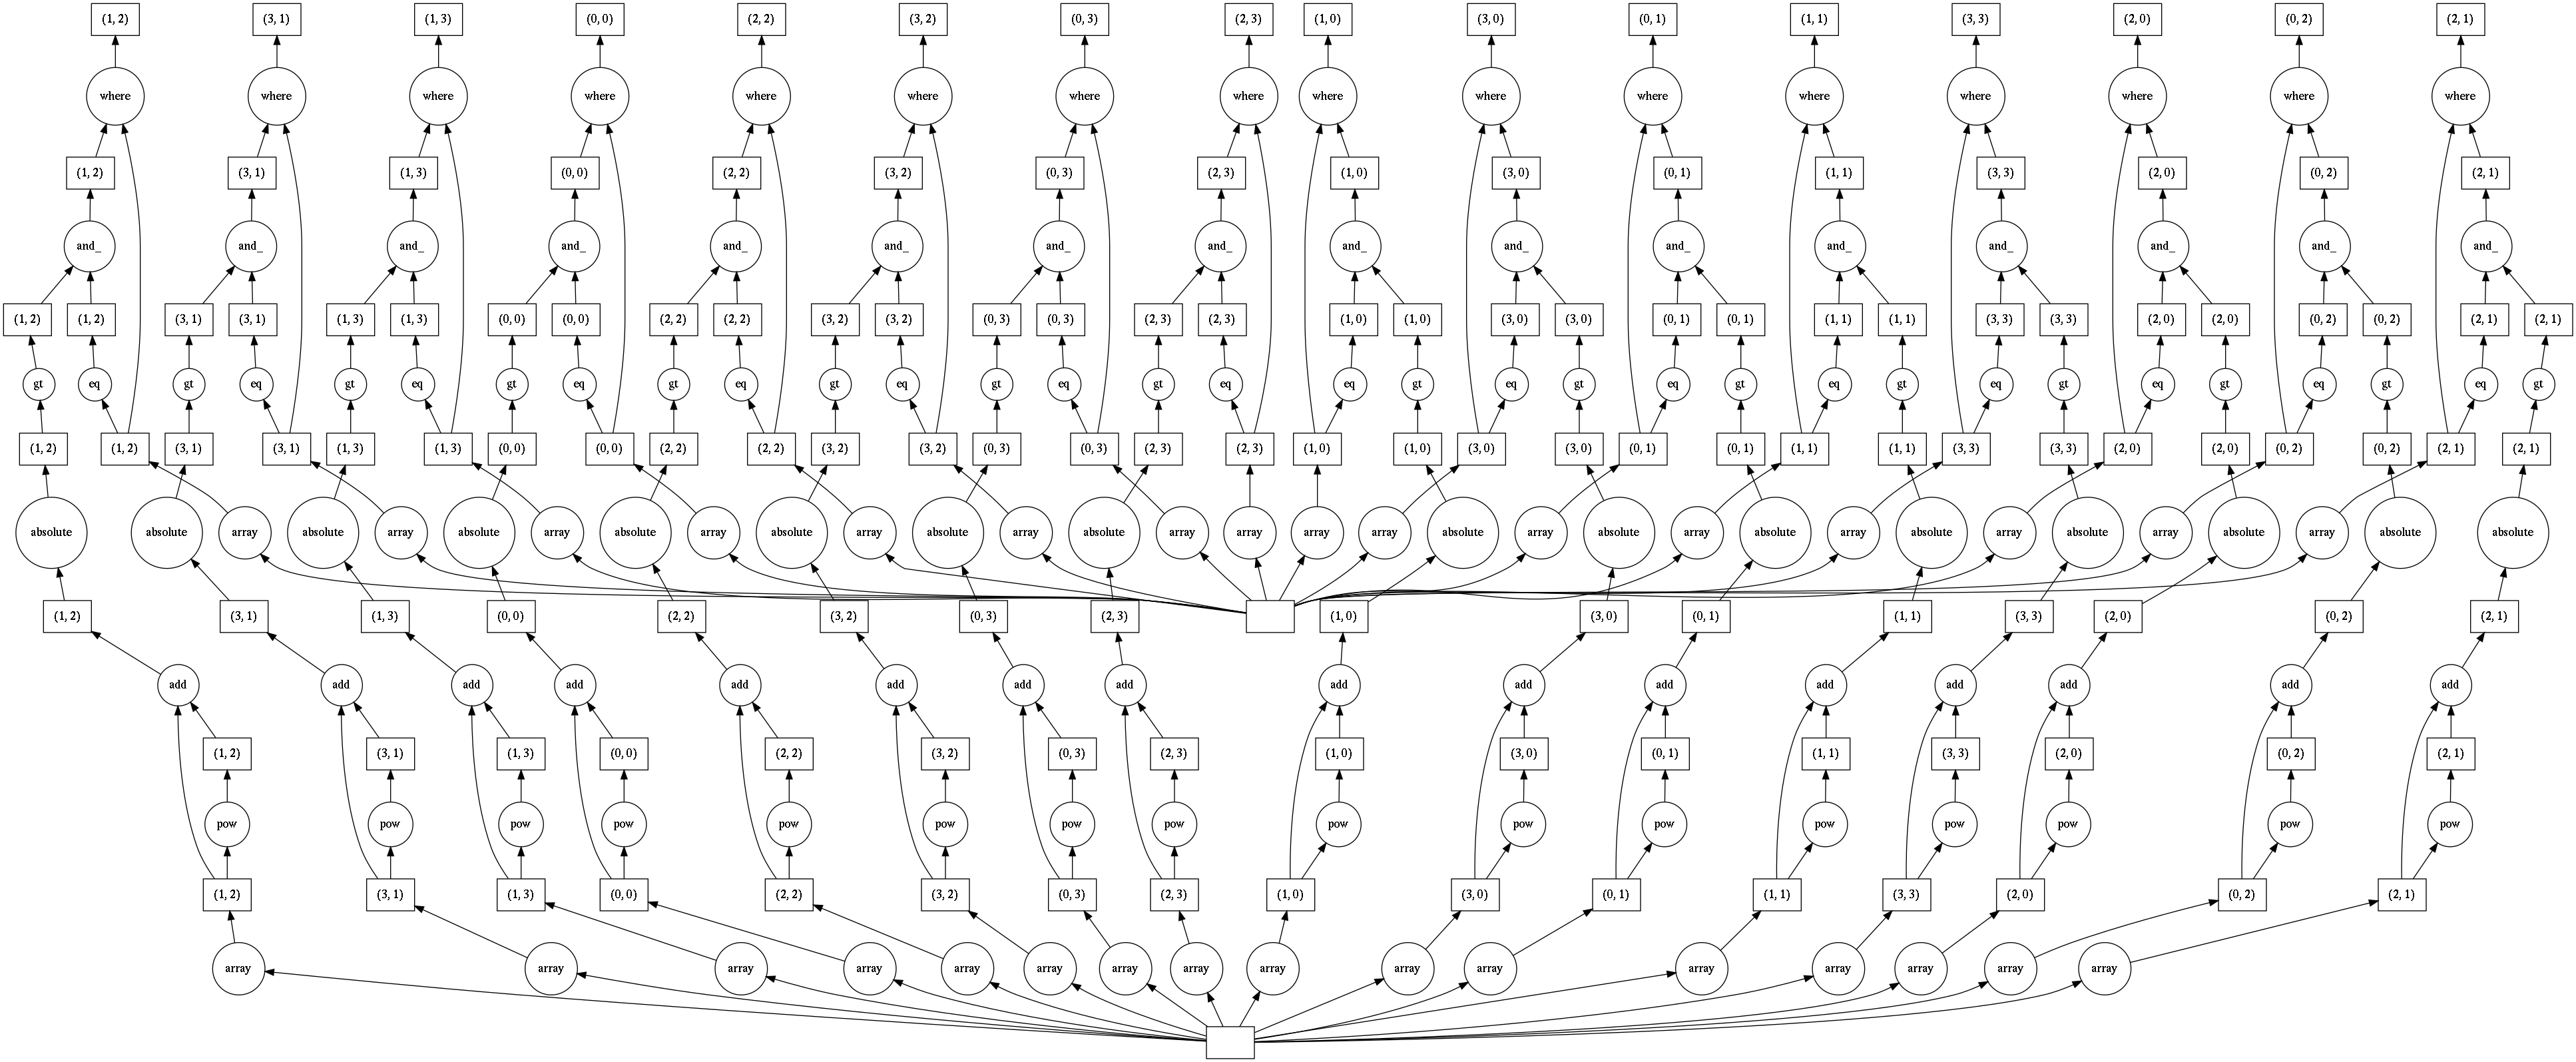

In [78]:
run_dask(1600, 2400, maxiterations=1, hchunks=3, vchunks=4).visualize()

In [82]:
# Numba, on the other hand, lets you run the original Python code, but faster.
import numba

@numba.jit
def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_numba(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

126.676835740606 ns per pixel
